# P06_PIV: Análisis PIV con Flujo Óptico de Farnebäck

Este notebook implementa un pipeline completo de análisis PIV (Velocimetría de Partículas por Imagen) usando flujo óptico denso (algoritmo de Farnebäck) para estimar campos de velocidad a partir de pares de imágenes. 

**Basado en el script `piv_utils.py`.**

Incluye:
- Explicación teórica de PIV y flujo óptico
- Descripción de la estructura de carpetas y archivos
- Implementación modular de utilidades y visualizaciones
- Procesamiento automático de todos los pares de imágenes
- Exportación de resultados y generación de reportes

---

## Índice
1. [Importar librerías y comprobar versiones](#section1)
2. [Configurar rutas de proyecto y creación de carpetas](#section2)
3. [Definir parámetros de Farnebäck y visualización](#section3)
4. [Utilidades: descubrir y cargar pares PIV](#section4)
5. [Flujo óptico denso (Farnebäck): implementación](#section5)
6. [Métricas de flujo: u, v, magnitud y vorticidad](#section6)
7. [Mallas para visualización (quiver/streamplot)](#section7)
8. [Visualización: campo de vectores (quiver)](#section8)
9. [Visualización: mapas de calor de magnitud y vorticidad](#section9)
10. [Visualización: líneas de corriente (streamplot)](#section10)
11. [Análisis: puntos extremos (máx/mín) y marcadores](#section11)
12. [Persistencia: exportar campos a CSV](#section12)
13. [Análisis: histogramas de magnitud y vorticidad](#section13)
14. [Reporte: generar Markdown con enlaces a figuras](#section14)
15. [Pipeline completo: procesar todos los pares encontrados](#section15)
16. [Verificación rápida: listar archivos generados](#section16)

---

## 1. Importar librerías y comprobar versiones

En esta sección se importan las librerías necesarias para el análisis PIV y se verifica la versión de OpenCV y NumPy. Se configura el estilo de matplotlib para visualizaciones consistentes.

**Librerías principales:**
- `cv2` (OpenCV): procesamiento de imágenes y cálculo de flujo óptico
- `numpy`: operaciones numéricas y de arrays
- `matplotlib.pyplot`, `matplotlib.cm`, `matplotlib.colors`: visualización
- `pandas`: exportación de datos a CSV
- `pathlib.Path`, `glob`: manejo de rutas y búsqueda de archivos


In [18]:
# Importar librerías principales
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import pandas as pd
from pathlib import Path
import glob

# Configurar estilo de matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

# Comprobar versiones
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

OpenCV version: 4.12.0
NumPy version: 2.2.6


## 2. Configurar rutas de proyecto y creación de carpetas

Se definen las rutas principales del proyecto usando `Path.cwd()` como referencia. Se crean los directorios de salida si no existen y se valida la existencia de imágenes de entrada en `files/p6/`.

**Estructura esperada:**
- `P06_PIV/` (este notebook)
- `data/` (resultados CSV)
- `data/images/` (figuras generadas)
- `../../files/p6/` (imágenes de entrada *_0.*, *_1.*)


In [19]:
# Definir rutas principales del proyecto
NOTEBOOK_DIR = Path.cwd()
# Si el notebook está dentro de la carpeta 'notebooks', subimos un nivel al proyecto P06_PIV
PROYECT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name.lower() == 'notebooks' else NOTEBOOK_DIR
DATA_DIR = PROYECT_DIR / 'data'
OUTPUT_DIR = DATA_DIR / 'images'
AERO_MESSURE_DIR = PROYECT_DIR.parent.parent
P6_FILES_DIR = AERO_MESSURE_DIR / 'files' / 'p6'

# Crear carpetas de salida si no existen
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Validar existencia de imágenes de entrada
archivos_0 = list(P6_FILES_DIR.glob('*_0.*'))
archivos_1 = list(P6_FILES_DIR.glob('*_1.*'))
print(f"Imágenes *_0.* encontradas: {len(archivos_0)}")
print(f"Imágenes *_1.* encontradas: {len(archivos_1)}")
if not archivos_0 or not archivos_1:
    print("Advertencia: No se encontraron suficientes pares de imágenes en files/p6/.")

Imágenes *_0.* encontradas: 1
Imágenes *_1.* encontradas: 2


## 3. Definir parámetros de Farnebäck y visualización

El algoritmo de Farnebäck para flujo óptico denso tiene varios parámetros clave:
- `pyr_scale`: escala de la pirámide de imágenes
- `levels`: número de niveles de la pirámide
- `winsize`: tamaño de la ventana de promedio
- `iterations`: iteraciones por nivel
- `poly_n`: tamaño del vecindario polinomial
- `poly_sigma`: sigma de la gaussiana para suavizado

También se define el parámetro `skip` para submuestreo en visualizaciones tipo quiver.


In [20]:
# Parámetros de Farnebäck y visualización
skip = 10  # Submuestreo para quiver
params_farneback = {
    'pyr_scale': 0.5,   # Escala de la pirámide (<1)
    'levels': 3,        # Niveles de la pirámide
    'winsize': 15,      # Tamaño de ventana
    'iterations': 3,    # Iteraciones por nivel
    'poly_n': 5,        # Vecindario polinomial
    'poly_sigma': 1.2   # Sigma de suavizado
}
print("Parámetros de Farnebäck:", params_farneback)
print(f"skip (submuestreo quiver): {skip}")

Parámetros de Farnebäck: {'pyr_scale': 0.5, 'levels': 3, 'winsize': 15, 'iterations': 3, 'poly_n': 5, 'poly_sigma': 1.2}
skip (submuestreo quiver): 10


## 4. Utilidades: descubrir y cargar pares PIV

Para procesar automáticamente todos los pares de imágenes, se implementan dos funciones:
- `encontrar_pares_piv(p6_files_dir)`: detecta todos los basenames que tienen ambos archivos *_0.* y *_1.*
- `cargar_par_imagenes(basename, p6_files_dir)`: carga el par de imágenes en escala de grises y retorna (img1, img2, basename)


In [21]:
def encontrar_pares_piv(p6_files_dir: Path):
    """
    Escanea el directorio de entrada y encuentra todos los pares PIV
    (basename_0, basename_1).
    Devuelve una lista de 'basenames' válidos (ej. ['B005', 'vortex_street']).
    """
    pares_encontrados = []
    archivos_0 = list(p6_files_dir.glob('*_0.*'))
    for path_0 in archivos_0:
        basename = path_0.stem.rsplit('_0', 1)[0]
        path_1_glob = list(p6_files_dir.glob(f'{basename}_1.*'))
        if path_1_glob:
            pares_encontrados.append(basename)
    return pares_encontrados

def cargar_par_imagenes(basename: str, p6_files_dir: Path):
    """
    Carga un par de imágenes (_0 y _1) desde el directorio de archivos P6.
    """
    img_a_path = list(p6_files_dir.glob(f'{basename}_0.*'))
    img_b_path = list(p6_files_dir.glob(f'{basename}_1.*'))
    if not img_a_path or not img_b_path:
        print(f"Error: No se encontraron imágenes para el basename '{basename}'")
        return None, None, None
    img1 = cv2.imread(str(img_a_path[0]), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(str(img_b_path[0]), cv2.IMREAD_GRAYSCALE)
    return img1, img2, basename

## 5. Flujo óptico denso (Farnebäck): implementación

El flujo óptico estima el desplazamiento de píxeles entre dos imágenes consecutivas bajo el principio de conservación de brillo:

$$
I(x, y, t) \approx I(x+u, y+v, t+\Delta t)
$$

Lo que lleva a la ecuación diferencial:

$$
I_x u + I_y v + I_t = 0
$$

El método de Farnebäck aproxima localmente la imagen con un polinomio cuadrático y estima desplazamientos coherentes entre niveles de una pirámide gaussiana.

Se utiliza la función `cv2.calcOpticalFlowFarneback` con el flag `OPTFLOW_FARNEBACK_GAUSSIAN` para mayor robustez al ruido.

In [22]:
def calcular_flujo_optico(img1, img2, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma):
    """
    Calcula el flujo óptico denso usando el algoritmo de Farnebäck.
    Retorna un array (h, w, 2) con los desplazamientos (u, v) por píxel.
    """
    flow = cv2.calcOpticalFlowFarneback(
        img1, img2, None,
        pyr_scale, levels, winsize,
        iterations, poly_n, poly_sigma,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
    )
    return flow

## 6. Métricas de flujo: u, v, magnitud y vorticidad

A partir del flujo óptico se extraen:
- $u$ y $v$: componentes horizontal y vertical del desplazamiento
- Magnitud de velocidad: $|\mathbf{V}| = \sqrt{u^2 + v^2}$
- Vorticidad: $\omega_z = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$

Se usan derivadas numéricas con `numpy.gradient`.

In [23]:
def calcular_metricas_flujo(flow):
    """
    Calcula u, v, magnitud de velocidad y vorticidad a partir del flujo óptico.
    """
    u = flow[..., 0]
    v = flow[..., 1]
    magnitude = np.sqrt(u**2 + v**2)
    grad_v = np.gradient(v)  # (dv/dy, dv/dx)
    grad_u = np.gradient(u)  # (du/dy, du/dx)
    dv_dx = grad_v[1]
    du_dy = grad_u[0]
    vorticity = dv_dx - du_dy
    return u, v, magnitude, vorticity

## 7. Mallas para visualización (quiver/streamplot)

Para graficar campos vectoriales y líneas de corriente, se generan mallas completas y submuestreadas usando `np.mgrid`.
- (x, y): malla completa
- (x_q, y_q): malla submuestreada para quiver


In [24]:
def preparar_visualizacion(shape, skip):
    """
    Prepara las mallas (grids) X, Y para visualización.
    Devuelve x, y (completos) y (x_q, y_q) submuestreados.
    """
    h, w = shape
    y, x = np.mgrid[0:h, 0:w]
    y_q, x_q = np.mgrid[skip//2:h:skip, skip//2:w:skip]
    return x, y, (x_q, y_q)

## 8. Visualización: campo de vectores (quiver)

Se grafica el campo de vectores de velocidad sobre la imagen base usando `plt.quiver`, submuestreando según `skip` para mayor claridad. Se superpone la imagen en escala de grises y se ajusta el aspecto.

In [25]:
def visualizar_vectores(x_q, y_q, u, v, skip, img, base_name, output_dir):
    """
    Visualiza el campo de vectores (quiver plot) sobre la imagen base.
    Guarda la figura en PNG y SVG y la muestra inline.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    u_q = u[skip//2:img.shape[0]:skip, skip//2:img.shape[1]:skip]
    v_q = v[skip//2:img.shape[0]:skip, skip//2:img.shape[1]:skip]
    ax.imshow(img, cmap='gray', alpha=0.6)
    ax.quiver(x_q, y_q, u_q, v_q, color='blue',
              scale=None, scale_units='xy', angles='xy', units='xy',
              width=0.1, headwidth=3, headlength=4, alpha=0.8)
    ax.set_title(f'Campo de Vectores (Quiver) - {base_name}')
    ax.set_xlabel('Posición X (píxeles)')
    ax.set_ylabel('Posición Y (píxeles)')
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    # Guardar y mostrar con la utilidad común
    _guardar_figura(fig, base_name, "vectores", output_dir, show=True)

## Utilidad: guardar figuras en PNG y SVG

Para consistencia, usamos una pequeña utilidad para guardar cada figura en ambos formatos.

In [26]:
from typing import Optional

def _guardar_figura(fig, base_name: str, tag: str, output_dir: Path, show: bool = True):
    """Guardar una figura con nombre base y etiqueta en PNG y SVG y mostrarla inline si show=True."""
    output_dir.mkdir(parents=True, exist_ok=True)
    filename_png = output_dir / f"{base_name}_{tag}.png"
    filename_svg = output_dir / f"{base_name}_{tag}.svg"
    fig.savefig(filename_png, dpi=150, bbox_inches='tight')
    fig.savefig(filename_svg, bbox_inches='tight')
    if show:
        plt.show()
    plt.close(fig)

## 9. Visualización: mapas de calor de magnitud y vorticidad

- Para magnitud: se usa escala de color `jet` con rango [min, max].
- Para vorticidad: conviene normalización simétrica en torno a 0 y un colormap bipolar (`seismic`).
- Los mapas usan `extent` para mostrar coordenadas de pixel (x, y) y `origin='lower'` para coherencia con `streamplot`.

In [27]:
def visualizar_mapa_calor(data, x, y, title, cmap, tag, base_name, output_dir, points_to_mark=None):
    """Visualiza un mapa de calor (imshow) para una métrica (magnitud, vorticidad)."""
    fig, ax = plt.subplots(figsize=(10, 8))
    if 'vorticidad' in tag.lower():
        vmax = np.nanmax(np.abs(data))
        vmin = -vmax
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    else:
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(
        data, cmap=cmap,
        extent=(x.min(), x.max(), y.min(), y.max()),
        origin='lower', norm=norm, interpolation='bilinear'
    )
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label(title)
    if points_to_mark:
        for (y_idx, x_idx), marker, label in points_to_mark:
            ax.plot(x_idx, y_idx, marker, markersize=10, label=label, markeredgecolor='black')
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    ax.set_title(f'{title} - {base_name}')
    ax.set_xlabel('Posición X (píxeles)')
    ax.set_ylabel('Posición Y (píxeles)')
    ax.set_aspect('equal')
    _guardar_figura(fig, base_name, tag, output_dir)
    plt.close(fig)


## 10. Visualización: líneas de corriente (streamplot)

Las líneas de corriente se dibujan con `ax.streamplot(x, y, u, v)`. Se colorean por magnitud y se superponen sobre la imagen base para contexto visual.

In [28]:
def visualizar_streamlines(x, y, u, v, img, base_name, output_dir):
    """Visualiza líneas de corriente (streamplot)."""
    fig, ax = plt.subplots(figsize=(10, 8))
    magnitude = np.sqrt(u**2 + v**2)
    ax.imshow(img, cmap='gray', alpha=0.4, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
    strm = ax.streamplot(x, y, u, v, color=magnitude, cmap=cm.jet, linewidth=1.5, density=1.5, arrowstyle='->')
    cbar = fig.colorbar(strm.lines, ax=ax, shrink=0.8)
    cbar.set_label('Magnitud de Velocidad')
    ax.set_title(f'Líneas de Corriente (Streamlines) - {base_name}')
    ax.set_xlabel('Posición X (píxeles)')
    ax.set_ylabel('Posición Y (píxeles)')
    ax.set_aspect('equal')
    _guardar_figura(fig, base_name, "streamlines", output_dir)
    plt.close(fig)


## 11. Análisis: puntos extremos (máx/mín) y marcadores

Se localizan los índices de máximos y mínimos de magnitud y vorticidad para utilizarlos como anotaciones en las figuras.

In [29]:
def analizar_puntos_extremos(magnitude, vorticity):
    """Encuentra y reporta los puntos de máx/mín magnitud y vorticidad."""
    max_mag_idx = np.unravel_index(np.argmax(magnitude), magnitude.shape)
    min_mag_idx = np.unravel_index(np.argmin(magnitude), magnitude.shape)
    max_vort_idx = np.unravel_index(np.argmax(vorticity), vorticity.shape)
    min_vort_idx = np.unravel_index(np.argmin(vorticity), vorticity.shape)
    print(f"Velocidad Máxima: {magnitude[max_mag_idx]:.3f} en (y={max_mag_idx[0]}, x={max_mag_idx[1]})")
    print(f"Vorticidad Máxima (+): {vorticity[max_vort_idx]:.3f} en (y={max_vort_idx[0]}, x={max_vort_idx[1]})")
    print(f"Vorticidad Mínima (-): {vorticity[min_vort_idx]:.3f} en (y={min_vort_idx[0]}, x={min_vort_idx[1]})")
    return {
        "max_mag": (max_mag_idx, 'w*', 'V máx'), 
        "min_mag": (min_mag_idx, 'wx', 'V mín'),
        "max_vort": (max_vort_idx, 'c+', 'Vort máx (+)'),
        "min_vort": (min_vort_idx, 'cx', 'Vort mín (-)')
    }


## 12. Persistencia: exportar campos a CSV

Se exportan los campos 2D (x, y, u, v, magnitud, vorticidad) a un archivo CSV por cada par procesado.

In [30]:
def guardar_datos_csv(u, v, magnitude, vorticity, base_name, data_dir: Path):
    """Guarda los campos 2D (u, v, magnitud, vorticidad) en un archivo CSV."""
    h, w = u.shape
    y_grid, x_grid = np.mgrid[0:h, 0:w]
    df = pd.DataFrame({
        'x': x_grid.flatten(),
        'y': y_grid.flatten(),
        'u': u.flatten(),
        'v': v.flatten(),
        'magnitud': magnitude.flatten(),
        'vorticidad': vorticity.flatten()
    })
    csv_path = data_dir / f"{base_name}_datos_piv.csv"
    df.to_csv(csv_path, index=False)
    print(f"CSV guardado: {csv_path}")


## 13. Análisis: histogramas de magnitud y vorticidad

Se generan histogramas con 100 bins, se limpia NaN/Inf, y se dibuja la línea de la media para referencia.

In [31]:
def visualizar_histograma(metric_data, title, tag, base_name, output_dir):
    """Crea y guarda un histograma de la distribución de una métrica."""
    fig, ax = plt.subplots(figsize=(8, 5))
    data_flat = metric_data.flatten()
    data_flat = data_flat[np.isfinite(data_flat)]
    ax.hist(data_flat, bins=100, density=True, color='c', edgecolor='k', alpha=0.7)
    mean_val = np.mean(data_flat)
    ax.axvline(mean_val, color='r', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    ax.set_title(f'Distribución de {title} - {base_name}')
    ax.set_xlabel(title)
    ax.set_ylabel('Densidad de Probabilidad')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    _guardar_figura(fig, base_name, tag, output_dir)
    plt.close(fig)


## 14. Reporte: generar Markdown con enlaces a figuras

Se construye un archivo `.md` por basename con las imágenes PNG y enlaces a SVG, organizado en secciones.

In [32]:
def generar_reporte_md(base_name, output_dir: Path):
    """Genera un archivo Markdown simple enlazando las figuras generadas."""
    tags = ['vectores', 'magnitud', 'vorticidad', 'streamlines', 'hist_magnitud', 'hist_vorticidad']
    lines = [f"# Reporte PIV: {base_name}\n"]
    for tag in tags:
        png_file = f"{base_name}_{tag}.png"
        svg_file = f"{base_name}_{tag}.svg"
        if (output_dir / png_file).exists():
            lines.append(f"## {tag.replace('_', ' ').capitalize()}")
            lines.append(f"![{tag}]({output_dir.name}/{png_file})")
            lines.append(f"[Descargar SVG]({output_dir.name}/{svg_file})")
            lines.append("")
    md_content = '\n'.join(lines)
    out_md = output_dir.parent / f'{base_name}_reporte.md'
    out_md.write_text(md_content, encoding='utf-8')
    print(f"Reporte generado: {out_md}")


## 15. Pipeline completo: procesar todos los pares encontrados

Orquestación del flujo completo:
1. Detectar basenames con `*_0.*` y `*_1.*`
2. Por cada basename: cargar imágenes, calcular flujo, métricas y mallas
3. Exportar CSV, analizar extremos y generar visualizaciones
4. Generar reporte Markdown por par procesado

--- Iniciando Análisis PIV ---
Directorio de Datos (Entrada): c:\Users\edgar\Documents\GitHub\Aero-Messure\files\p6
Directorio de Datos (Salida CSV): c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data
Directorio de Imágenes (Salida): c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images
Se procesarán 1 pares de imágenes.

-----------------------------------------------------------------
Procesando Par 1/1: rankine_vortex03
-----------------------------------------------------------------
CSV guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\rankine_vortex03_datos_piv.csv
Velocidad Máxima: 2.219 en (y=459, x=97)
Vorticidad Máxima (+): 0.763 en (y=339, x=249)
Vorticidad Mínima (-): -0.738 en (y=424, x=305)
CSV guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\rankine_vortex03_datos_piv.csv
Velocidad Máxima: 2.219 en (y=459, x=97)
Vorticidad Máxima (+): 0.763 en (y=339, x=249)
Vorticidad Mínima (

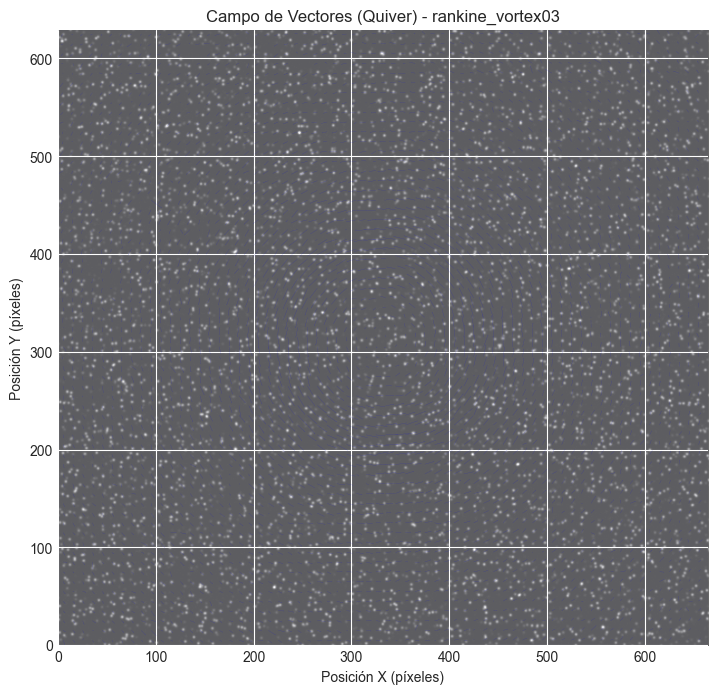

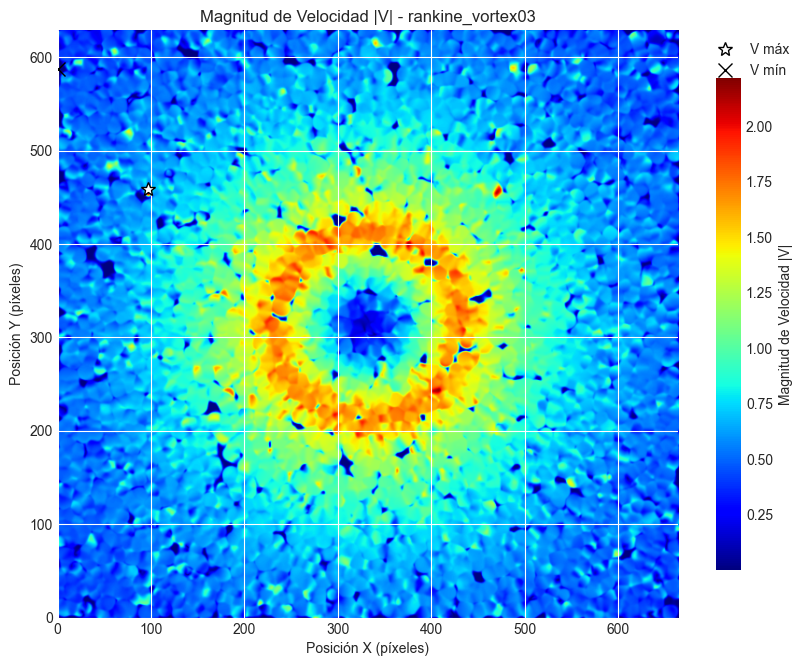

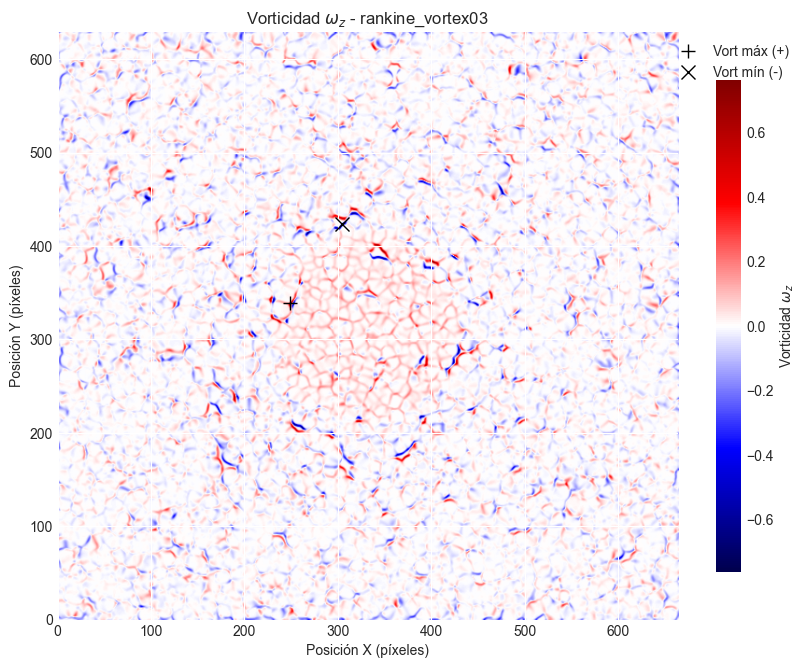

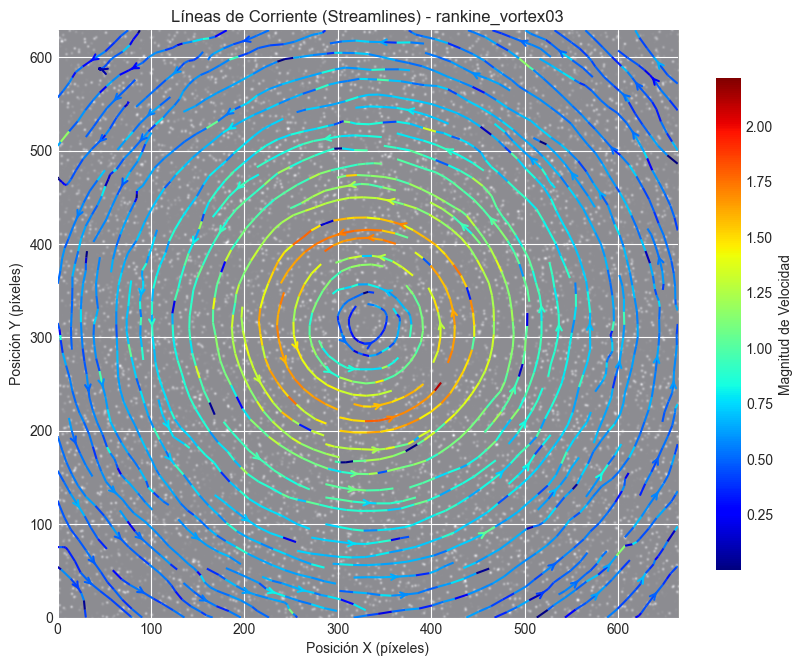

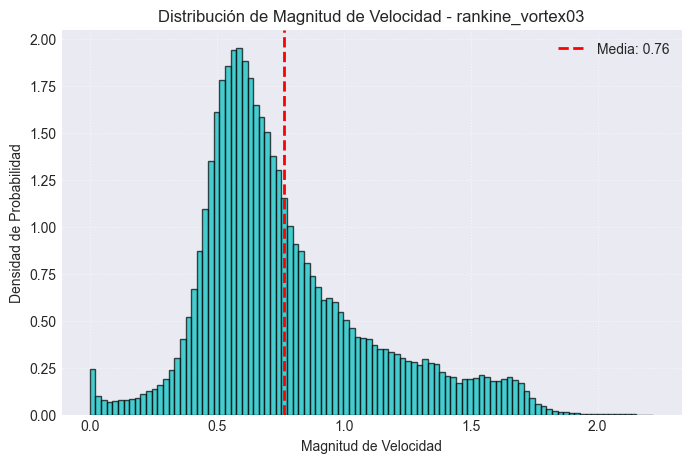

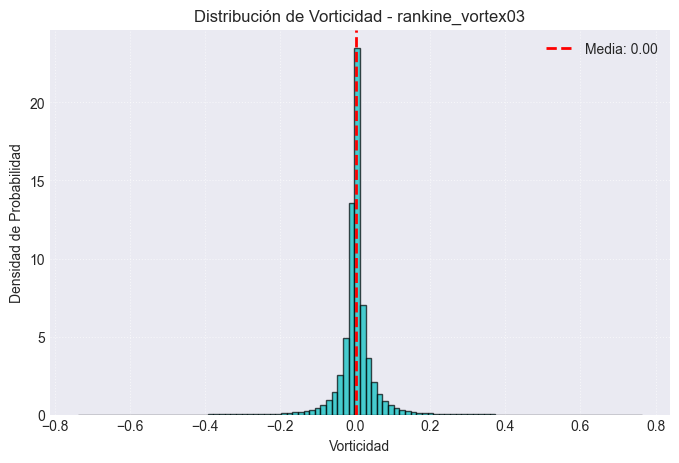

Reporte generado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\rankine_vortex03_reporte.md
Fin del procesamiento de rankine_vortex03

--- Análisis PIV finalizado ---


In [33]:
# Ejecutar pipeline completo (esta celda procesa todos los pares disponibles)
print("--- Iniciando Análisis PIV ---")
print(f"Directorio de Datos (Entrada): {P6_FILES_DIR}")
print(f"Directorio de Datos (Salida CSV): {DATA_DIR}")
print(f"Directorio de Imágenes (Salida): {OUTPUT_DIR}")

basenames = encontrar_pares_piv(P6_FILES_DIR)
if not basenames:
    print("No se encontraron pares válidos (basename_0.* y basename_1.*).")
else:
    print(f"Se procesarán {len(basenames)} pares de imágenes.")

for i, basename in enumerate(basenames, start=1):
    print("\n" + "-"*65)
    print(f"Procesando Par {i}/{len(basenames)}: {basename}")
    print("-"*65)
    # 1. Cargar imágenes
    img1, img2, base_name = cargar_par_imagenes(basename, P6_FILES_DIR)
    if img1 is None:
        print(f"Error al cargar {basename}, se omite.")
        continue
    # 2. Flujo óptico
    flow = calcular_flujo_optico(img1, img2, **params_farneback)
    # 3. Métricas
    u, v, magnitude, vorticity = calcular_metricas_flujo(flow)
    # 4. Mallas
    x, y, (x_q, y_q) = preparar_visualizacion(img1.shape, skip)
    # 5. CSV
    guardar_datos_csv(u, v, magnitude, vorticity, base_name, DATA_DIR)
    # 6. Extremos
    extremos = analizar_puntos_extremos(magnitude, vorticity)
    mag_points = [extremos["max_mag"], extremos["min_mag"]]
    vort_points = [extremos["max_vort"], extremos["min_vort"]]
    # 7. Visualizaciones
    visualizar_vectores(x_q, y_q, u, v, skip, img1, base_name, OUTPUT_DIR)
    visualizar_mapa_calor(magnitude, x, y, 'Magnitud de Velocidad |V|', cm.jet, 
                          'magnitud', base_name, OUTPUT_DIR,
                          points_to_mark=mag_points)
    visualizar_mapa_calor(vorticity, x, y, 'Vorticidad $\\omega_z$', cm.seismic, 
                          'vorticidad', base_name, OUTPUT_DIR,
                          points_to_mark=vort_points)
    visualizar_streamlines(x, y, u, v, img1, base_name, OUTPUT_DIR)
    # 8. Histogramas
    visualizar_histograma(magnitude, 'Magnitud de Velocidad', 'hist_magnitud', base_name, OUTPUT_DIR)
    visualizar_histograma(vorticity, 'Vorticidad', 'hist_vorticidad', base_name, OUTPUT_DIR)
    # 9. Reporte
    generar_reporte_md(base_name, OUTPUT_DIR)
    print(f"Fin del procesamiento de {basename}")

print("\n--- Análisis PIV finalizado ---")

## 16. Verificación rápida: listar archivos generados

Se listan los archivos generados en `data/` y `data/images/` (CSV, PNG, SVG, MD) y se muestran algunos ejemplos.

In [34]:
# Listar archivos generados
pngs = sorted(OUTPUT_DIR.glob('*.png'))
svgs = sorted(OUTPUT_DIR.glob('*.svg'))
mds = sorted(DATA_DIR.glob('*_reporte.md'))
csvs = sorted(DATA_DIR.glob('*_datos_piv.csv'))
print(f"PNGs: {len(pngs)} | SVGs: {len(svgs)} | CSVs: {len(csvs)} | MDs: {len(mds)}")
for sample in (pngs[:3] + svgs[:3] + csvs[:3] + mds[:3]):
    print(" -", sample)

PNGs: 6 | SVGs: 6 | CSVs: 1 | MDs: 1
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images\rankine_vortex03_hist_magnitud.png
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images\rankine_vortex03_hist_vorticidad.png
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images\rankine_vortex03_magnitud.png
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images\rankine_vortex03_hist_magnitud.svg
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images\rankine_vortex03_hist_vorticidad.svg
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images\rankine_vortex03_magnitud.svg
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\rankine_vortex03_datos_piv.csv
 - c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\rankine_vortex03_reporte.md


## 17. Interpretación de resultados y guía de lectura

Esta sección resume cómo leer e interpretar cada salida del pipeline.

### Campo de vectores (quiver)
- Vectores largos indican mayor desplazamiento local entre imágenes (mayor velocidad aparente).
- Campos casi uniformes sugieren traslación global; gradientes marcan cizalla; vectores que cambian de dirección definen recirculaciones.
- En índices de imagen, el eje Y crece hacia abajo; por eso se invierte para visualizar con orientación cartesiana.
- Submuestreo `skip`: demasiados vectores pueden ocultar patrones; aumentar `skip` para limpiar, reducirlo para más detalle.

### Mapa de magnitud |V|
- Zonas calientes (amarillo/rojo en `jet`) = mayor velocidad; zonas frías (azul) = baja velocidad.
- Bordes de objetos o capas de cizalla suelen concentrar gradientes de magnitud.
- Si la escala está saturada (máximos muy altos), ajustar la ventana (`winsize`) o suavizado (`poly_sigma`) para estabilizar.

### Mapa de vorticidad ωz
- Convención: ωz > 0 (giro anti-horario), ωz < 0 (giro horario). El colormap bipolar (`seismic`) y normalización simétrica facilitan comparar.
- Núcleos compactos de vorticidad suelen marcar vórtices; bandas alternas indican calles de vórtices (p.ej., Von Kármán).
- Los marcadores de extremos ayudan a localizar centros de giro o regiones de mayor cizalla.

### Líneas de corriente (streamlines)
- Muestran la topología del campo: recirculaciones (lóbulos cerrados), separaciones, uniones y puntos silla.
- Coloreadas por |V| para contextualizar zonas de alta/baja velocidad.
- Útiles para validar coherencia global: las líneas deberían seguir el patrón esperado del experimento.

### Histogramas
- |V|: 
  - Picos cerca de cero indican regiones extensas de baja velocidad o deslizamiento mínimo.
  - Colas largas sugieren jets, bordes de capas o movimiento fuera del plano que induce aparente desplazamiento.
- ωz:
  - Distribuciones simétricas alrededor de 0 indican balance de giros horario/antihorario; sesgo sugiere dominancia de un sentido.
  - Anchura (desviación típica) refleja intensidad promedio de cizalla/rotación.

### Datos CSV (x, y, u, v, magnitud, vorticidad)
- Están en unidades de píxel por intervalo de tiempo entre imágenes (frame). Para convertir a unidades físicas (m/s):
  - Calibración espacial: factor de escala [m/px] (p.ej., con patrón o dimensiones conocidas).
  - Calibración temporal: Δt entre imágenes (segundos).
  - Entonces: U[m/s] = u[px] · (m/px) / Δt; V[m/s] = v[px] · (m/px) / Δt.
- Con el CSV puedes:
  - Calcular promedios espaciales, perfiles, integrales de flujo, y análisis espectral tras postprocesado.

### Artefactos típicos y ajustes
- Cambios de iluminación o bajo sembrado (pocas partículas) → flujo ruidoso. Aumentar `winsize`, `poly_sigma` y/o `levels` puede ayudar.
- Estructuras muy finas que se suavizan → reducir `winsize` y `poly_sigma`, o bajar `pyr_scale` y `levels` para menos alisado piramidal.
- Desplazamientos grandes entre frames → aumentar `levels` y `winsize`.
- Bordes de imagen: gradientes menos fiables por padding; interpretar con cautela.

### Siguientes pasos recomendados
- Aplicar máscaras (ROI) para excluir paredes o zonas sin señal.
- Filtrar el campo (medianas/gaussiano ligero) y/o realizar validación de outliers (p.ej., umbrales de magnitud/vorticidad).
- Convertir a unidades físicas con calibración y reportar incertidumbre.
- Comparar con PIV clásico por correlación cruzada (ventanas multipaso) si se requiere mayor robustez en flujos complejos.
